In [12]:
import pickle
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm

from backtester.options import Option, OptionChain, Loader
from backtester.strategy import Leg, Strategy
from backtester.pds import PDS, PDSStrategy

In [20]:
%load_ext autoreload

In [198]:
%autoreload 2

In [194]:
%autoreload 0

# HMM Model

## Training

In [459]:
train = yf.Ticker("GOOGL").history(start="2001-01-01", end="2017-12-31")['Close'].to_frame().pct_change().dropna()
test = yf.Ticker("GOOGL").history(start="2018-01-01", end="2020-12-31")['Close'].to_frame().pct_change().dropna()

model = hmm.GaussianHMM(n_components=2, n_iter=100, covariance_type="full")
model.fit(train)
test_res = model.predict_proba(test)

test_res = test_res[:,1]
#test_res = np.where(np.expand_dims(test_res, 0) < 0.9, 1, 0)

regime = yf.Ticker("GOOGL").history(start="2018-01-01", end="2020-12-31")['Close'][1:].to_frame()
regime['regime'] = test_res.flatten()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

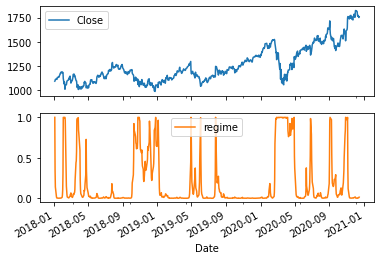

In [460]:
regime.plot(subplots=True)

In [1017]:
pickle.dump(model, open( "./models/goog_hmm.pkl", "wb" ) )

In [2]:
def load_regime(model_file, ticker, start, end, today:tuple = None, col=0): #today(date: str[yyyy-mm-dd], price)
    model = pickle.load(open(model_file,"rb"))
    
    price = yf.Ticker(ticker).history(start=start, end=end)['Close'].to_frame()
    
    if today:
        today = pd.DataFrame([today[1]], index=[np.datetime64(today[0])], columns=['Close'])
        price = price.append(today)
    
    data = price.pct_change().dropna()
    
    regime = np.zeros(len(data))
    
    for idx in range(len(data)):
        regime[idx] = model.predict_proba(data.iloc[0:idx + 1])[-1,col]
    
    
    price = price[1:]
    price['regime'] = regime
    return price

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

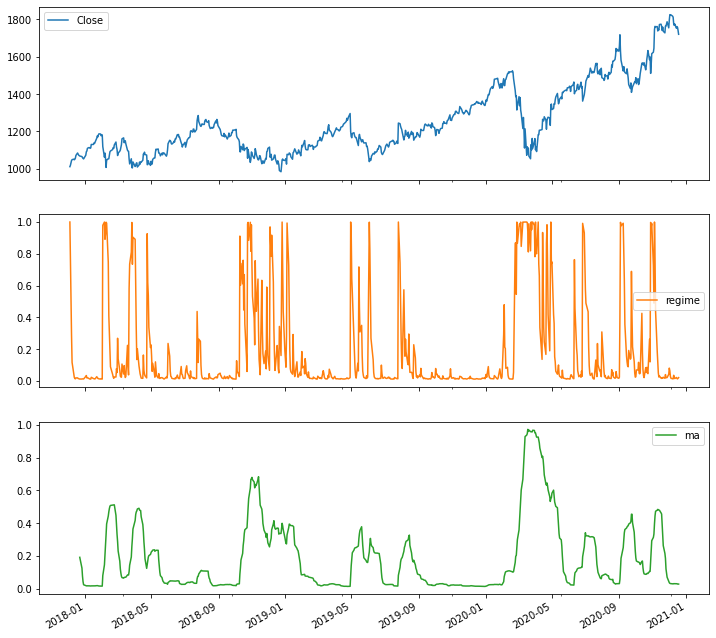

In [3]:
googl_regime = load_regime('./models/googl_hmm.pkl', "GOOGL", "2017-12-01", "2020-12-18", today=("2020-12-18", 1720), col=1)
googl_regime['ma'] = googl_regime['regime'].rolling(15).mean()
googl_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

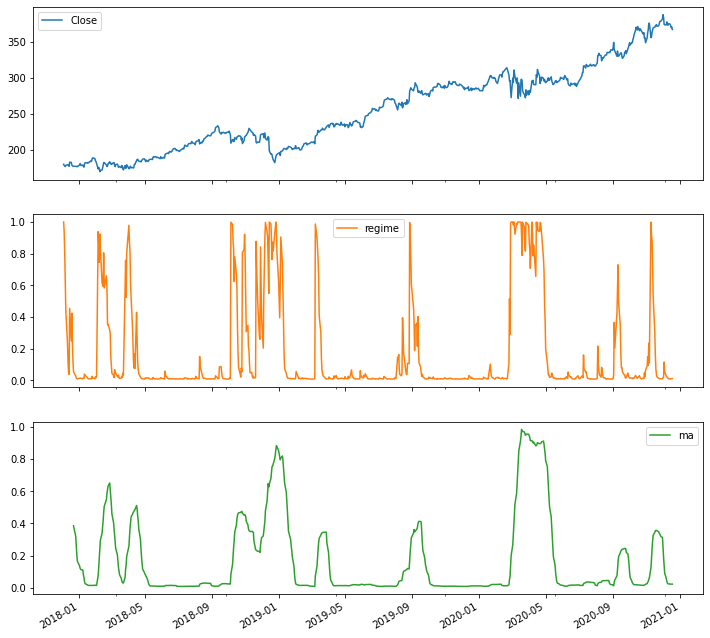

In [4]:
cost_regime = load_regime('./models/cost_hmm.pkl', "COST", "2017-12-01", "2020-12-18", today=("2020-12-18", 367), col=1)
cost_regime['ma'] = cost_regime['regime'].rolling(15).mean()
cost_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

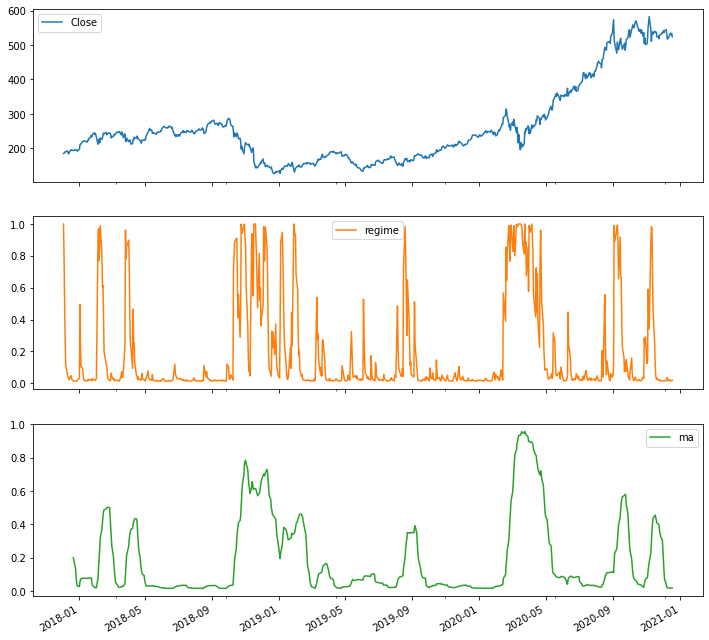

In [5]:
nvda_regime = load_regime('./models/nvda_hmm.pkl', "NVDA", "2017-12-01", "2020-12-18",today=("2020-12-18", 524), col=1)
nvda_regime['ma'] = nvda_regime['regime'].rolling(15).mean()
nvda_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

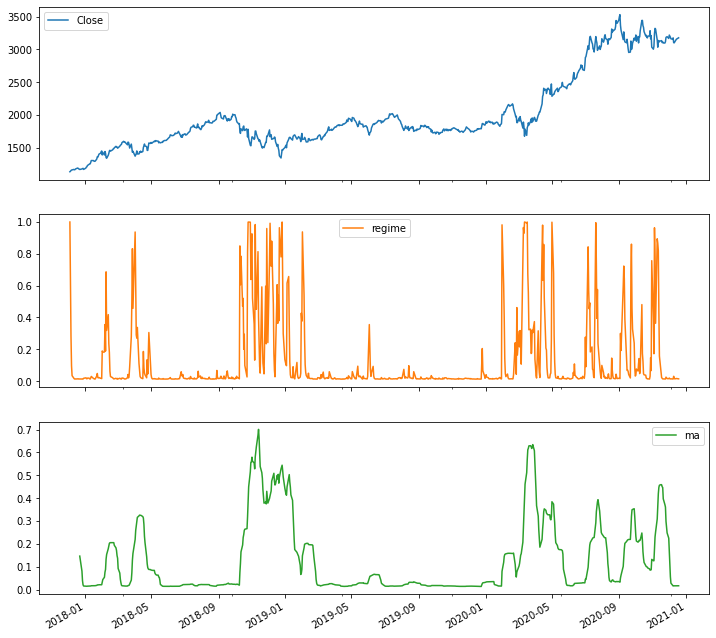

In [6]:
amzn_regime = load_regime('./models/amzn_hmm.pkl', "AMZN", "2017-12-01", "2020-12-15", today=("2020-12-18", 3178),col=0)
amzn_regime['ma'] = amzn_regime['regime'].rolling(15).mean()
amzn_regime.plot(subplots=True, figsize=(12,12))

In [7]:
def googl_decider(date):
    if googl_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def cost_decider(date):
    if cost_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def nvda_decider(date):
    if nvda_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def amzn_decider(date):
    if amzn_regime.loc[date]['ma'] > 0.4:
        return False

    return True

In [602]:
def decider_short(date):
    if regime.loc[date]['regime'] > 0.9:
        return True

    return False

In [56]:
decider(np.datetime64('2018-01-24'))

True

# Option Strat Backtest

In [8]:
data_paths = [f"./data/{f}" for f in listdir('./data') if isfile(join('./data', f))]

In [9]:
# load data
loader = Loader()
loader.load_data(data_paths, True)

In [156]:
mnyness = 0.97
mnyness_long = 0.83

In [157]:
leg_1 = Leg(loader, np.datetime64('2018-01-05'))
leg_1.ticker = "GOOGL"
leg_1.side = 's'
leg_1.quantity = 3
leg_1.opt_type = 'put'
leg_1.tenor_day = 7
leg_1.moneyness = mnyness
leg_1.open_frequency_d = 'roll'
leg_1.close_n_tday_before = 0
leg_1.open_px = 'mid'
leg_1.close_px = 'mid'
leg_1.decider = googl_decider

leg_2 = Leg(loader, np.datetime64('2018-01-05'))
leg_2.ticker = "AMZN"
leg_2.side = 's'
leg_2.quantity = 2
leg_2.opt_type = 'put'
leg_2.tenor_day = 7
leg_2.moneyness = mnyness
leg_2.open_frequency_d = 'roll'
leg_2.close_n_tday_before = 0
leg_2.open_px = 'mid'
leg_2.close_px = 'mid'
leg_2.decider = amzn_decider

leg_3 = Leg(loader, np.datetime64('2018-01-05'))
leg_3.ticker = "NVDA"
leg_3.side = 's'
leg_3.quantity = 15
leg_3.opt_type = 'put'
leg_3.tenor_day = 7
leg_3.moneyness = mnyness
leg_3.open_frequency_d = 'roll'
leg_3.close_n_tday_before = 0
leg_3.open_px = 'mid'
leg_3.close_px = 'mid'
leg_3.decider = nvda_decider

leg_4 = Leg(loader, np.datetime64('2018-01-05'))
leg_4.ticker = "COST"
leg_4.side = 's'
leg_4.quantity = 18
leg_4.opt_type = 'put'
leg_4.tenor_day = 7
leg_4.moneyness = mnyness
leg_4.open_frequency_d = 'roll'
leg_4.close_n_tday_before = 0
leg_4.open_px = 'mid'
leg_4.close_px = 'mid'
leg_4.decider = cost_decider

#----------------------------------------------------

leg_5 = Leg(loader, np.datetime64('2018-01-05'))
leg_5.ticker = "GOOGL"
leg_5.side = 'l'
leg_5.quantity = 3
leg_5.opt_type = 'put'
leg_5.tenor_day = 30
leg_5.moneyness = mnyness_long
leg_5.open_frequency_d = 7
leg_5.close_n_tday_before = 15
leg_5.open_px = 'mid'
leg_5.close_px = 'mid'
leg_5.decider = googl_decider

leg_6 = Leg(loader, np.datetime64('2018-01-05'))
leg_6.ticker = "AMZN"
leg_6.side = 'l'
leg_6.quantity = 2
leg_6.opt_type = 'put'
leg_6.tenor_day = 30
leg_6.moneyness = mnyness_long
leg_6.open_frequency_d = 7
leg_6.close_n_tday_before = 15
leg_6.open_px = 'mid'
leg_6.close_px = 'mid'
leg_6.decider = amzn_decider

leg_7 = Leg(loader, np.datetime64('2018-01-05'))
leg_7.ticker = "NVDA"
leg_7.side = 'l'
leg_7.quantity = 15
leg_7.opt_type = 'put'
leg_7.tenor_day = 30
leg_7.moneyness = mnyness_long
leg_7.open_frequency_d = 7
leg_7.close_n_tday_before = 15
leg_7.open_px = 'mid'
leg_7.close_px = 'mid'
leg_7.decider = nvda_decider

leg_8 = Leg(loader, np.datetime64('2018-01-05'))
leg_8.ticker = "COST"
leg_8.side = 'l'
leg_8.quantity = 18
leg_8.opt_type = 'put'
leg_8.tenor_day = 30
leg_8.moneyness = mnyness_long
leg_8.open_frequency_d = 7
leg_8.close_n_tday_before = 15
leg_8.open_px = 'mid'
leg_8.close_px = 'mid'
leg_8.decider = cost_decider

In [158]:
strategy = Strategy([leg_1, leg_2, leg_3, leg_4, leg_5, leg_6, leg_7, leg_8])
df_res = strategy.get_stats()

In [159]:
df_res["cumulative_unreal_pnl"].iloc[-1]

386971.0

In [160]:
df_res["drawdown"].min()

-91616.0

In [161]:
df_res["cumulative_unreal_pnl"].min()

-26362.0

In [330]:
money = (0.97, 0.83)

In [331]:
pds_1 = PDS(loader, np.datetime64('2018-01-05'))
pds_1.ticker = "AMZN"
pds_1.moneyness = money
pds_1.initial_cap = 49000.0
pds_1.tenor = (7, 30)
pds_1.open_px = 'mid'
pds_1.close_px = 'mid'
pds_1.decider = amzn_decider

pds_2 = PDS(loader, np.datetime64('2018-01-05'))
pds_2.ticker = "GOOGL"
pds_2.moneyness = money
pds_2.initial_cap = 49000.0
pds_2.tenor = (7, 30)
pds_2.open_px = 'mid'
pds_2.close_px = 'mid'
pds_2.decider = googl_decider

pds_3 = PDS(loader, np.datetime64('2018-01-05'))
pds_3.ticker = "COST"
pds_3.moneyness = money
pds_3.initial_cap = 49000.0
pds_3.tenor = (7, 30)
pds_3.open_px = 'mid'
pds_3.close_px = 'mid'
pds_3.decider = cost_decider

pds_4 = PDS(loader, np.datetime64('2018-01-05'))
pds_4.ticker = "NVDA"
pds_4.moneyness = money
pds_4.initial_cap = 49000.0
pds_4.tenor = (7, 30)
pds_4.open_px = 'mid'
pds_4.close_px = 'mid'
pds_4.decider = nvda_decider

In [332]:
pds_strat = PDSStrategy([pds_1,pds_2,pds_3,pds_4])
df_res = pds_strat.get_stats()

In [333]:
df_res["capital"].iloc[-1]

1295812.5

In [334]:
df_res["drawdown"].min()

-0.3316740618519922

In [335]:
df_res["capital"].min()

177004.0

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

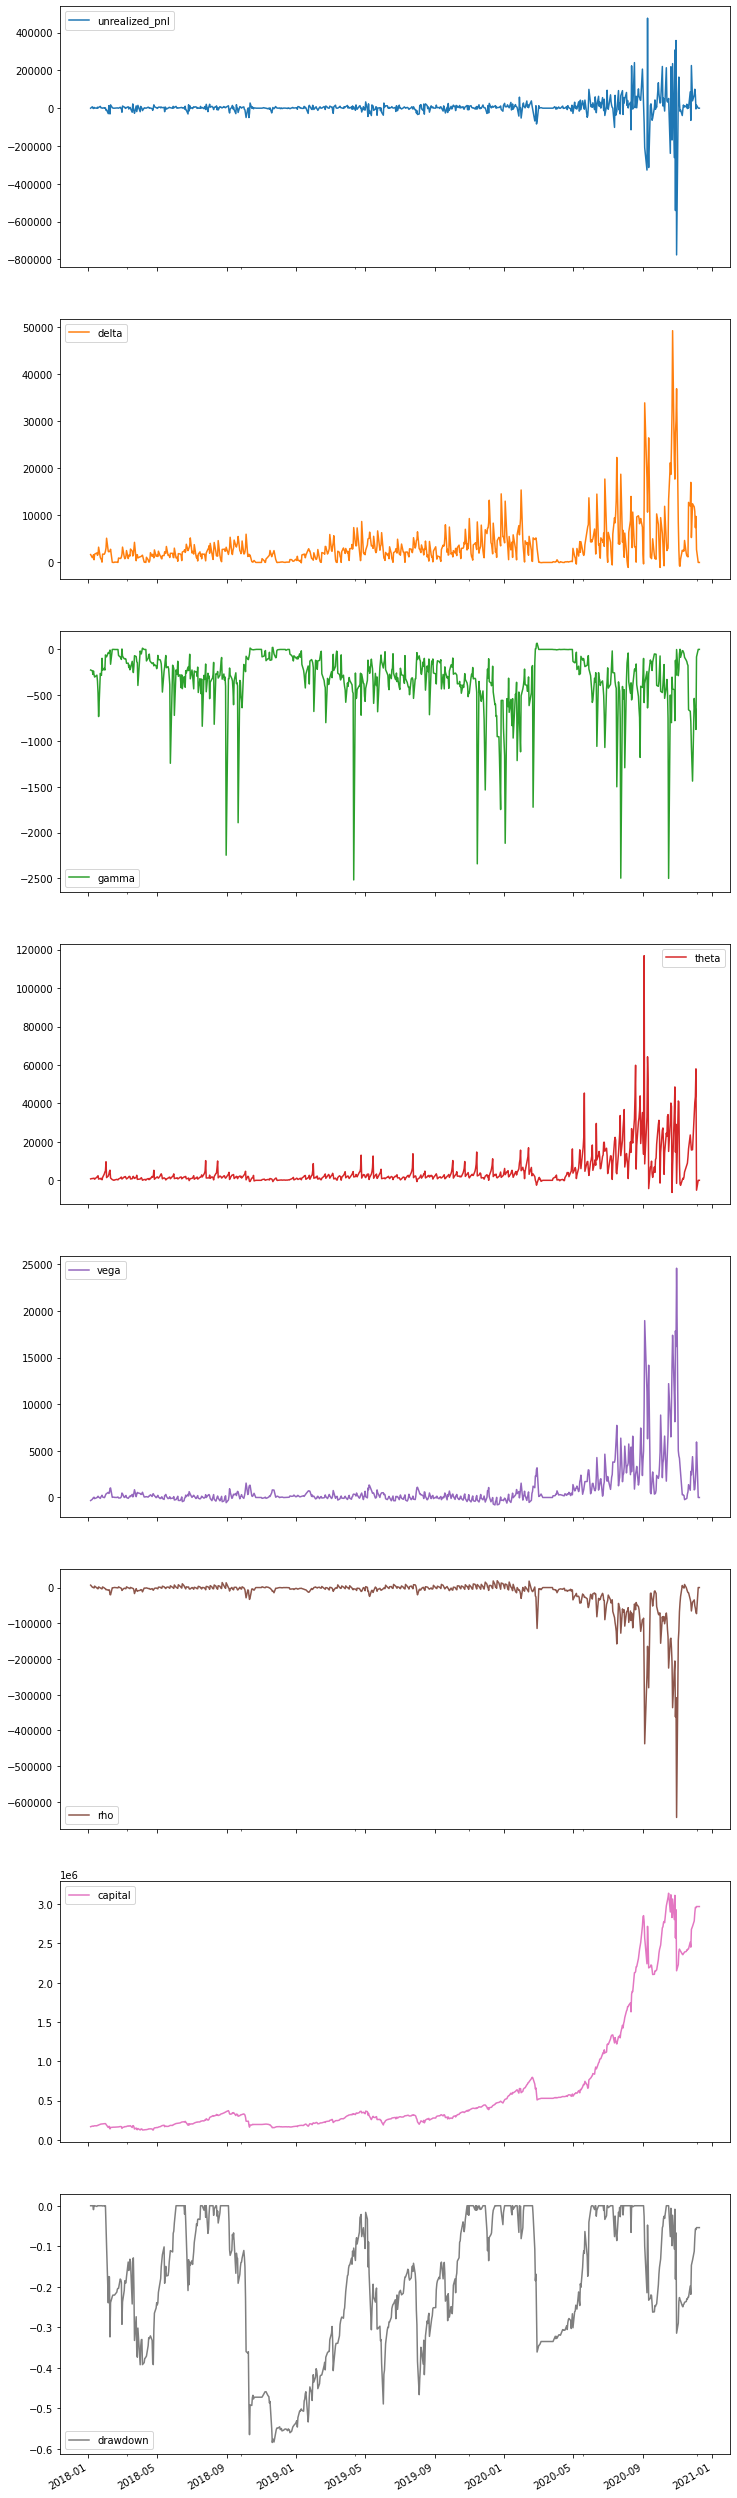

In [318]:
df_res.plot(subplots=True, figsize=(12,50))

In [173]:
df_res["capital"].pct_change()

2018-01-05         NaN
2018-01-08    0.061254
2018-01-09   -0.003803
2018-01-10   -0.010965
2018-01-11    0.032220
                ...   
2020-12-03    0.000000
2020-12-04    0.000000
2020-12-07    0.000000
2020-12-08    0.000000
2020-12-09    0.000000
Name: capital, Length: 738, dtype: float64

In [180]:
df_res["capital"].pct_change().describe()

count    737.000000
mean       0.006018
std        0.064026
min       -0.297490
25%       -0.004050
50%        0.008350
75%        0.030859
max        0.340726
Name: capital, dtype: float64

<AxesSubplot:>

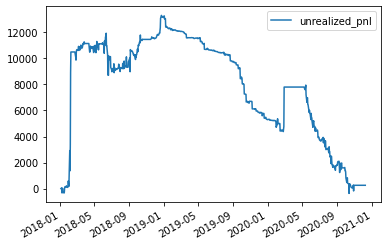

In [134]:
test[0].cumsum().plot()

In [117]:
test[1].loc[np.datetime64("2020-04-27")][0] == 0

True

In [49]:
pds_1.get_margin(pds_1.trades[0][2],pds_1.trades[0][3])

11000.0

In [50]:
pds_1.get_multiplier('s', 30000, 11000)

-300

In [262]:
test_chain = OptionChain("AMZN", np.datetime64("2020-12-12"))

In [263]:
load["amzn"]["2019"]

In [303]:
series = df['cumulative_unreal_pnl'].to_numpy()

In [318]:
df_test = pd.DataFrame().values

In [323]:
df["drawdown"] = (series - np.fmax.accumulate(series))

In [165]:
df_res.loc[np.datetime64("2018-01-05")]

realized_pnl                0.00
unrealized_pnl              0.00
delta                     516.33
gamma                    -120.30
theta                     482.30
vega                     -205.23
rho                      1338.92
cumulative_real_pnl         0.00
cumulative_unreal_pnl       0.00
drawdown                    0.00
Name: 2018-01-05 00:00:00, dtype: float64

In [1332]:
surface = surf.get_vol_surface("GOOGL", np.datetime64('2020-01-28'), [7, 23, 60, 90], "moneyness")


In [1333]:
surface =surface.reset_index()

In [1334]:
surface = surface.sort_values(by=['index'])

Text(0.5, 1.0, '2020-12-08 Vol Surface')

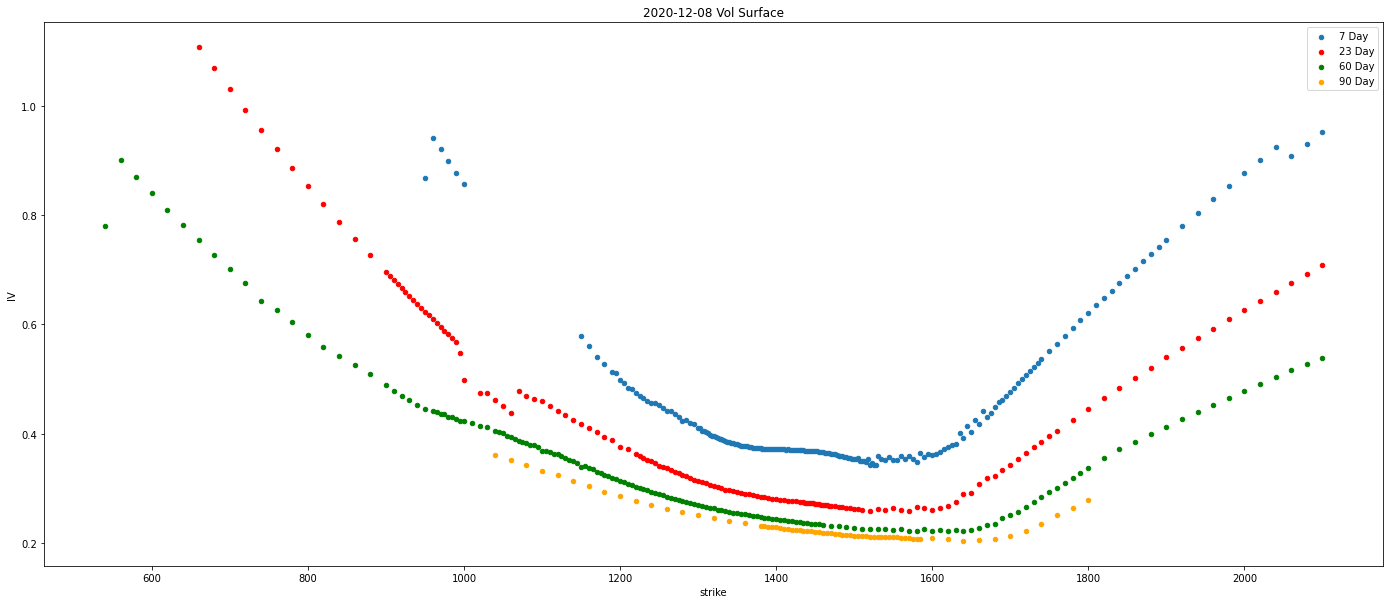

In [1336]:
ax = surface.plot.scatter(x='index', y=7, label="7 Day", figsize=(24,10))
surface.plot.scatter(x='index', y=23, color='red', label="23 Day", ax=ax)
surface.plot.scatter(x='index', y=60, color='green', label="60 Day", ax=ax)
surface.plot.scatter(x='index', y=90, color='orange', label="90 Day", ax=ax)

ax.set_xlabel("strike")
ax.set_ylabel("IV")
ax.set_title("2020-12-08 Vol Surface")

In [774]:
t_d = {"foo": [2, 5, 8]}

In [779]:
t_d.values()


dict_values([[2, 5, 8]])